In [69]:
from dotenv import load_dotenv
load_dotenv()

MAX_TOKENS = 1000

In [134]:
from openai import OpenAI
import groq
from anthropic import Anthropic
from pydantic import BaseModel
import instructor
import base64

class StatementInfo(BaseModel):
    is_true: int
    # reason: str

def get_prompt(table_data: str, statement: str, img_url: str):
    prompt = [
            {
                "role": "system",
                "content": f"You are a helpful assistant who can understand structured table data. You need to help identify if a statement is True/False based on the data of {caption}: \n\n{table_data}. Response should only contain a single character 1 for True or 0 for False.",
            },
            {
                "role": "user",
                "content": f"{statement}"
            }
        ]
    return prompt
    
def get_openai_response(prompt: list) -> str:
    """Get response from OpenAI's model"""
    client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
    # response = client.chat.completions.create(
    response = client.beta.chat.completions.parse(
        model=os.getenv('OPENAI_MODEL'),  # Use from settings
        messages=prompt,
        max_tokens=MAX_TOKENS,  # Use from settings
        response_format=StatementInfo
    )
    result = response.choices[0].message.parsed #.choices[0].message.content
    return result.is_true

def get_groq_llama_response(prompt: list) -> str:
    """Get response from Groq's Llama model"""
    client = instructor.from_groq(groq.Groq(api_key=os.getenv('GROQ_API_KEY')), mode=instructor.Mode.JSON)
    # client = groq.Groq(api_key=os.getenv('GROQ_API_KEY'))
    response = client.chat.completions.create(
        model=os.getenv('GROQ_LLAMA_MODEL'),
        messages=prompt,
        max_tokens=MAX_TOKENS,
        response_model=StatementInfo
    )
    return response.is_true
    # return response.choices[0].message.content

def get_groq_mixtral_response(prompt: list) -> str:
    """Get response from Groq's Mixtral model"""
    try: 
        client = instructor.from_groq(groq.Groq(api_key=os.getenv('GROQ_API_KEY')), mode=instructor.Mode.JSON)
        # client = groq.Groq(api_key=os.getenv('GROQ_API_KEY'))
        response = client.chat.completions.create(
            model=os.getenv('GROQ_MIXTRAL_MODEL'),
            messages=prompt,
            max_tokens=MAX_TOKENS,
            response_model=StatementInfo
        )
        # print(response)
        return response.is_true
        # return response.choices[0].message.content
    except:
        return None

def get_claude_response(prompt: list) -> str:
    try:
        """Get response from Anthropic's Claude"""
        # client = Anthropic(api_key=os.getenv('CLAUDE_API_KEY'))
        client = instructor.from_anthropic(Anthropic(api_key=os.getenv('CLAUDE_API_KEY')))
        response = client.messages.create(
            model=os.getenv('CLAUDE_MODEL'),  # We'll add this to settings
            system=prompt[0]['content'],
            messages=[prompt[1]],
            max_tokens=MAX_TOKENS+1,
            response_model=StatementInfo
        )
        return response.is_true #response.content[0].text
    except:
        return None

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
      
def get_image_prompt(img_url: str, statement: str, caption: str):
    base64_image = encode_image(img_url)
    prompt = [
            {
                "role": "user",
                "content":
                [
                    {
                        "type": "text",                         
                        "text": f"You are a helpful assistant who can understand structured table data and images. You need to help identify if a statement is True/False based on the data represented in the image. The data is related to {caption}. Please respond with a JSON object containing two keys: 'is_true' (1 for True, 0 for False) and 'reason' (a brief explanation of your answer). For example: {{'is_true': 1, 'reason': 'statement is true based on the data'}}",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    },
                    {
                        "type": "text",
                        "text":f"{statement}"
                    }
                ],
            }
        ]
    return prompt
    
def get_llama_vision_response(prompt: list) -> str:
    client=groq.Groq(api_key=os.getenv('GROQ_API_KEY'))
    chat_completion = client.chat.completions.create(
        messages= prompt,
        model="llama-3.2-11b-vision-preview",
        response_format={"type": "json_object"}
        # temperature=0,
        # max_completion_tokens=MAX_TOKENS+1,
        # top_p=0,
        # response_model=StatementInfo
        # stream=False,
        # stop=None,
    )
    return chat_completion.choices[0].message.content

In [2]:
# load test file 
import json 
file_path = "./test_examples.json"
with open(file_path, 'r') as file:
    test_examples = json.load(file)

target_list = list(test_examples.keys())[:10]


In [3]:
import pandas as pd

data = pd.read_csv(f'./all_csv/{target_list[2]}', sep='#')
data

,no overall,no for series,title,directed by,written by,original air date,uk viewers (million)
0,14,1,the curse of cornelius sigan,david moore,julian jones,19 september 2009,5.77
1,15,2,the once and future queen,jeremy webb,howard overman,26 september 2009,5.94
2,16,3,the nightmare begins,jeremy webb,ben vanstone,3 october 2009,6.09
3,17,4,lancelot and guinevere,david moore,howard overman,10 october 2009,5.69
4,18,5,beauty and the beast (part 1),david moore,jake michie,24 october 2009,5.53
5,19,6,beauty and the beast (part 2),metin huseyin,ben vanstone,31 october 2009,6.14
6,20,7,the witchfinder,jeremy webb,jake michie,7 november 2009,5.62
7,21,8,the sins of the father,metin huseyin,howard overman,14 november 2009,6.16
8,22,9,the lady of the lake,metin huseyin,julian jones,21 november 2009,6.30
9,23,10,sweet dreams,alice troughton,lucy watkins,28 november 2009,6.02


In [31]:
questions = test_examples[target_list[0]]

In [169]:
eval_data = pd.DataFrame(columns=['key', 'prompt', 'expected_result', 'openai_result', 'llama_result', 'mixtral_result', 'claude_result'])
for t_index, table_Key in enumerate(target_list):
    table_data = pd.read_csv(f'./all_csv/{table_Key}', sep='#')
    questions = test_examples[table_Key]
    for q_index, q in enumerate(questions[0]):
        expected_result = questions[1][q_index]
        prompt = get_prompt(table_data.to_string(), q, questions[2])
        eval_data.loc[len(eval_data)] = {'key': table_Key, 'prompt': prompt, 'expected_result': expected_result}


In [170]:
eval_data

,key,prompt,expected_result,openai_result,llama_result,mixtral_result,claude_result
0,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
1,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
2,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
3,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
4,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
94,2-17340355-10.html.csv,"[{'role': 'system', 'content': 'You are a help...",0,NaN,NaN,NaN,NaN
95,2-17340355-10.html.csv,"[{'role': 'system', 'content': 'You are a help...",0,NaN,NaN,NaN,NaN
96,2-17340355-10.html.csv,"[{'role': 'system', 'content': 'You are a help...",0,NaN,NaN,NaN,NaN
97,2-17340355-10.html.csv,"[{'role': 'system', 'content': 'You are a help...",0,NaN,NaN,NaN,NaN


In [172]:
eval_data.iloc[0, 1]

[{'role': 'system',
  'content': 'You are a helpful assistant who can understand structured table data. You need to help identify if a statement is True/False based on the data of tony lema: \n\n              tournament  wins  top - 5  top - 10  top - 25  events  cuts made\n0     masters tournament     0        1         2         4       4          4\n1                us open     0        2         3         4       6          5\n2  the open championship     1        2         2         2       3          3\n3       pga championship     0        0         1         2       5          4\n4                 totals     1        5         8        12      18         16. Response should only contain a single character 1 for True or 0 for False.'},
 {'role': 'user',
  'content': 'tony lema be in the top 5 for the master tournament , the us open , and the open championship'}]

In [188]:
eval_data['openai_result'] = eval_data['prompt'].apply(lambda x : int(get_openai_response(x)))
eval_data['llama_result'] = eval_data['prompt'].apply(get_groq_llama_response)
eval_data['mixtral_result'] = eval_data['prompt'].apply(get_groq_mixtral_response)
eval_data['claude_result'] = eval_data['prompt'].apply(get_claude_response)

In [195]:
eval_data.head()

,key,prompt,expected_result,openai_result,llama_result,mixtral_result,claude_result
0,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,0,0.0,1
1,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,1.0,1
2,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,1.0,1
3,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,0.0,1
4,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,0,1.0,1


In [190]:
eval_data['claude_result'] = eval_data['prompt'].apply(get_claude_response)


Accuracy OpenAI: 0.88, Llama: 0.76, Mixtral: 0.58, Claude: 0.84


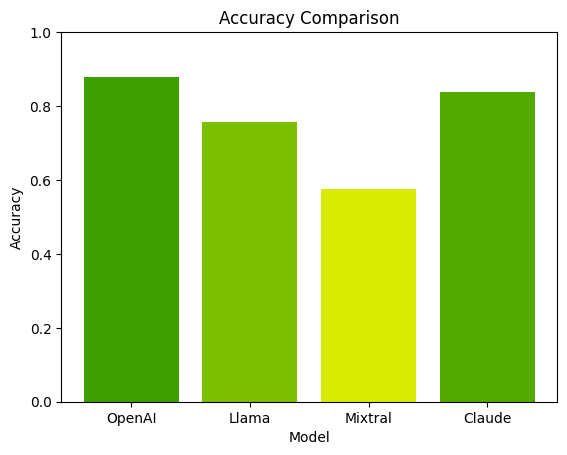

In [191]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime


# eval_data

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'results_{timestamp}.json'
eval_data.to_json(f'./table_fact_check/{filename}', orient='records')

# eval_data['openai_result'] = eval_data['openai_result'].apply(lambda x : int(x))


df = eval_data
accuracy_openai = (df['expected_result'] == df['openai_result']).mean()
accuracy_llama = (df['expected_result'] == df['llama_result']).mean()
accuracy_mixtral = (df['expected_result'] == df['mixtral_result']).mean()
accuracy_claude = (df['expected_result'] == df['claude_result']).mean()
print(f'Accuracy OpenAI: {accuracy_openai:.2f}, Llama: {accuracy_llama:.2f}, Mixtral: {accuracy_mixtral:.2f}, Claude: {accuracy_claude:.2f}')


# Define a custom colormap
cmap = LinearSegmentedColormap.from_list("custom", ["red", "yellow", "green"])
methods = ['OpenAI', 'Llama', 'Mixtral', 'Claude']
accuracy = [accuracy_openai, accuracy_llama, accuracy_mixtral, accuracy_claude]
# Normalize the accuracy values to be between 0 and 1
norm = plt.Normalize(vmin=0, vmax=1)
# Create a bar chart with colored bars
for i, (method, acc) in enumerate(zip(methods, accuracy)):
    plt.bar(i, acc, color=cmap(norm(acc)))
# Set the title and labels
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(range(len(methods)), methods)
plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
# Show the plot
plt.show()

In [ ]:
# vision model 



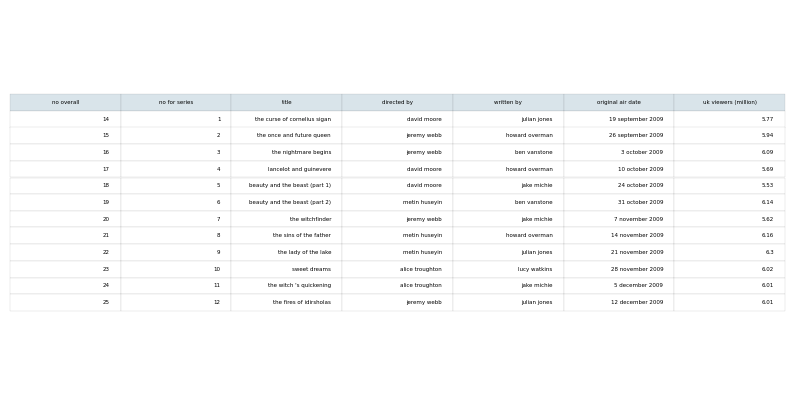

In [35]:
# create an image of the table

import pandas as pd
import matplotlib.pyplot as plt
import os
# Load the CSV file
# df = pd.read_csv('your_file.csv')
df = data
# Convert DataFrame to HTML
html_table = df.to_html()
# Render the HTML to an image using Matplotlib
# Note: This step directly renders the DataFrame, not the HTML.
plt.figure(figsize=(10, 5))
plt.axis('off')  # Turn off axis
table = plt.table(cellText=df.values, colLabels=df.columns, loc='center', colColours=['#D9E4EA']*len(df))
for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(0.05)
new_file_name = os.path.splitext(target_list[2])[0] + '.png'
# plt.savefig(f'./csv_images/{new_file_name}', bbox_inches='tight')

In [30]:
eval_data

NameError: name 'eval_data' is not defined

In [31]:
import json 
eval_data_results = pd.read_json(f'./table_fact_check/results_2025-02-14_01-48-00.json')
eval_data_results.head()


,key,prompt,expected_result,openai_result,llama_result,mixtral_result,claude_result
0,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,0,0.0,1
1,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,1.0,1
2,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,1.0,1
3,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,0.0,1
4,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,0,1.0,1


In [44]:
file_path = "./test_examples.json"
test_examples = pd.read_json(file_path)

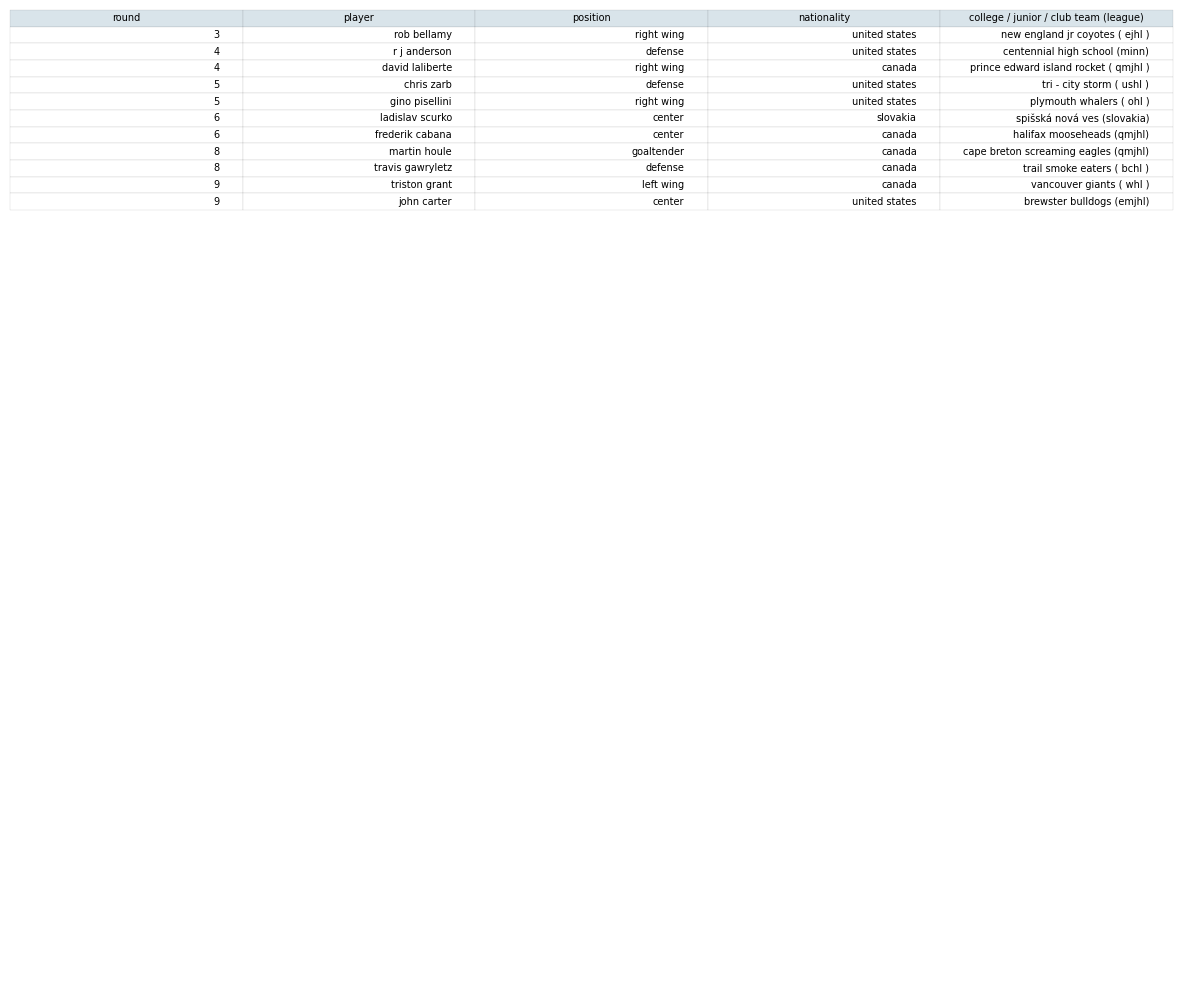

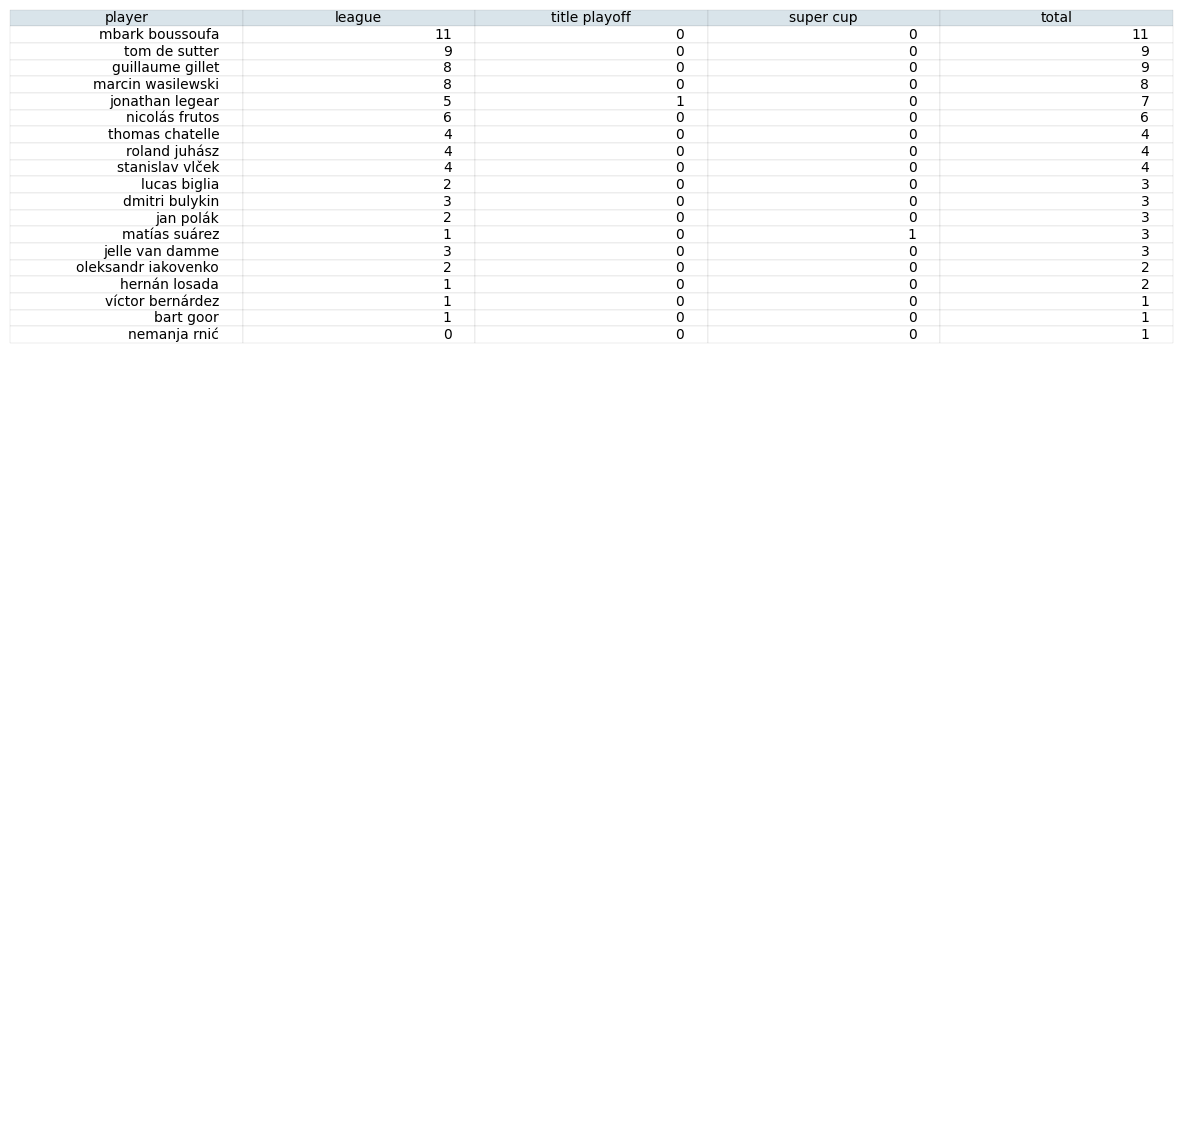

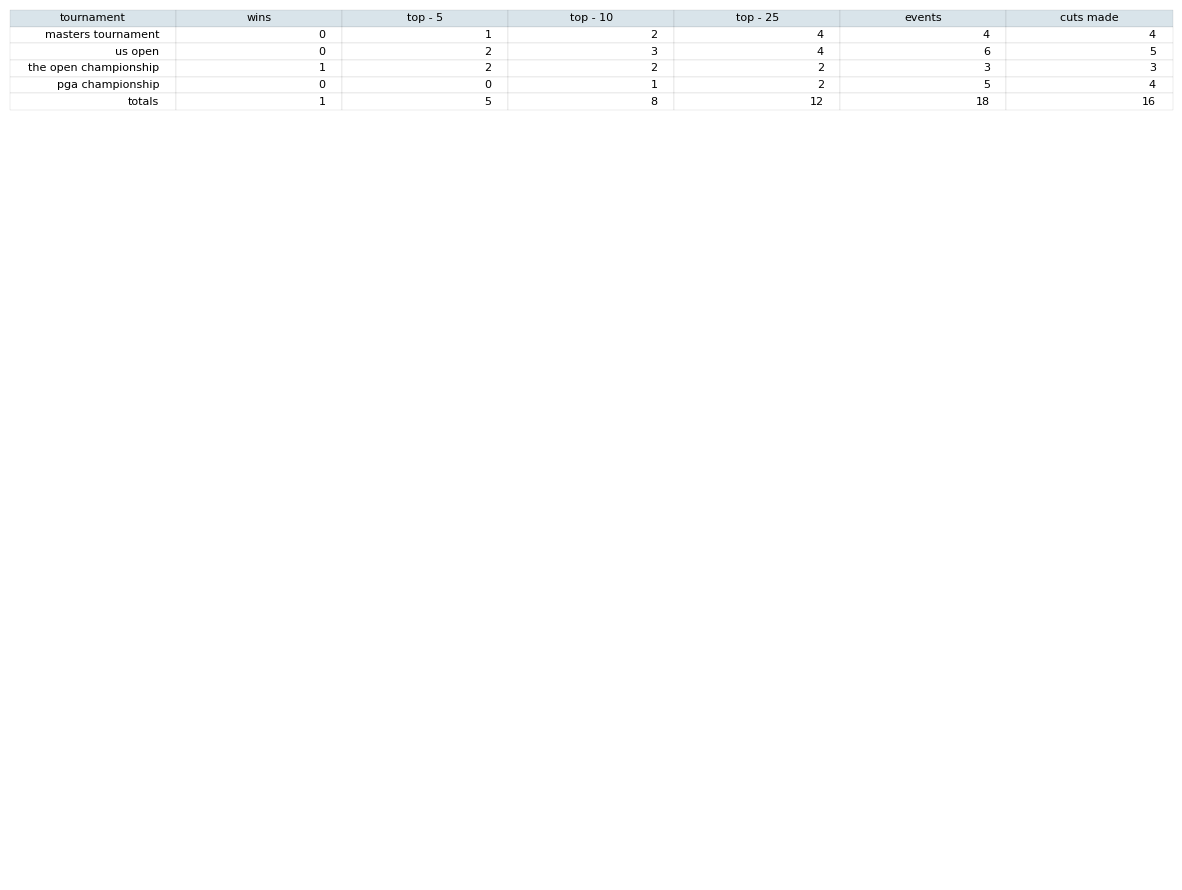

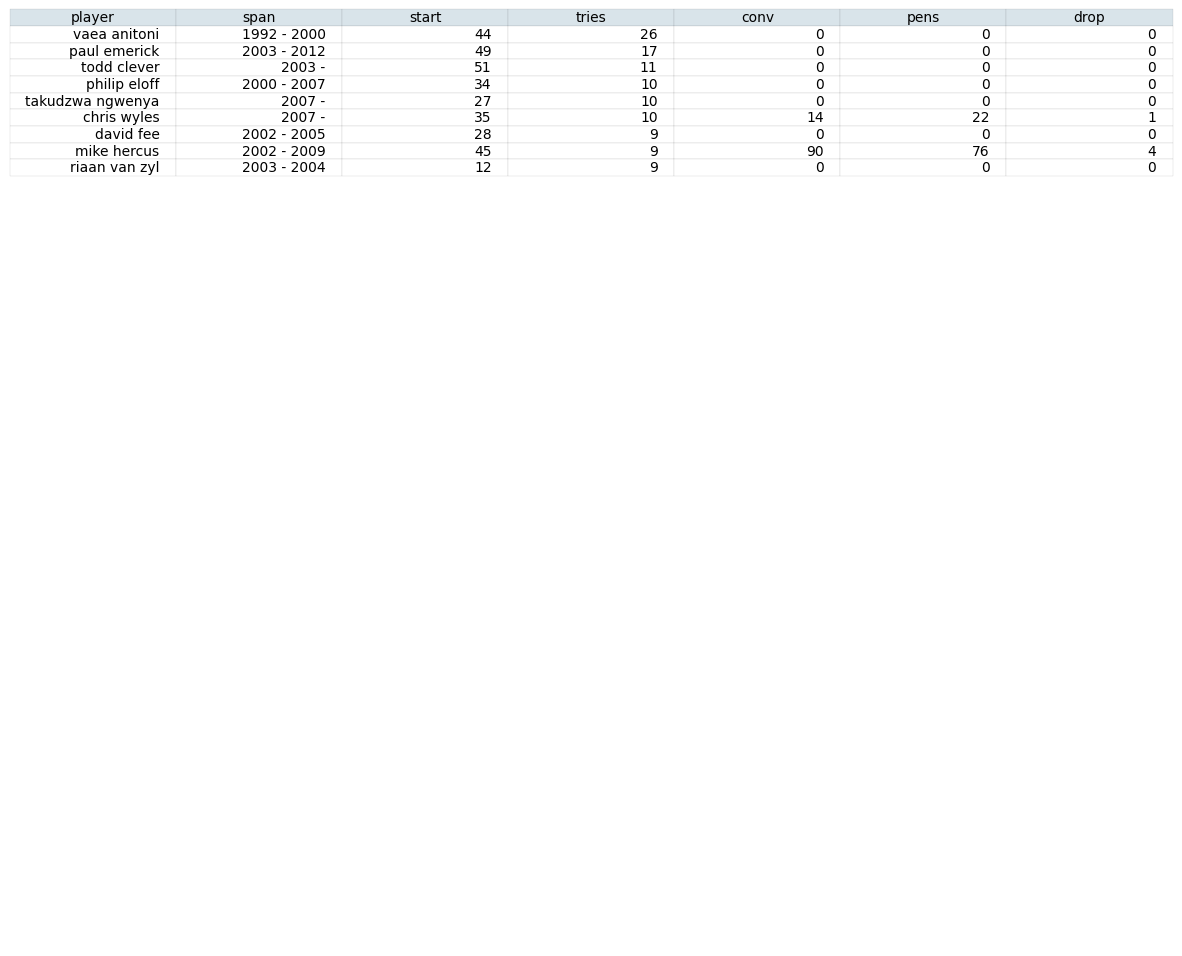

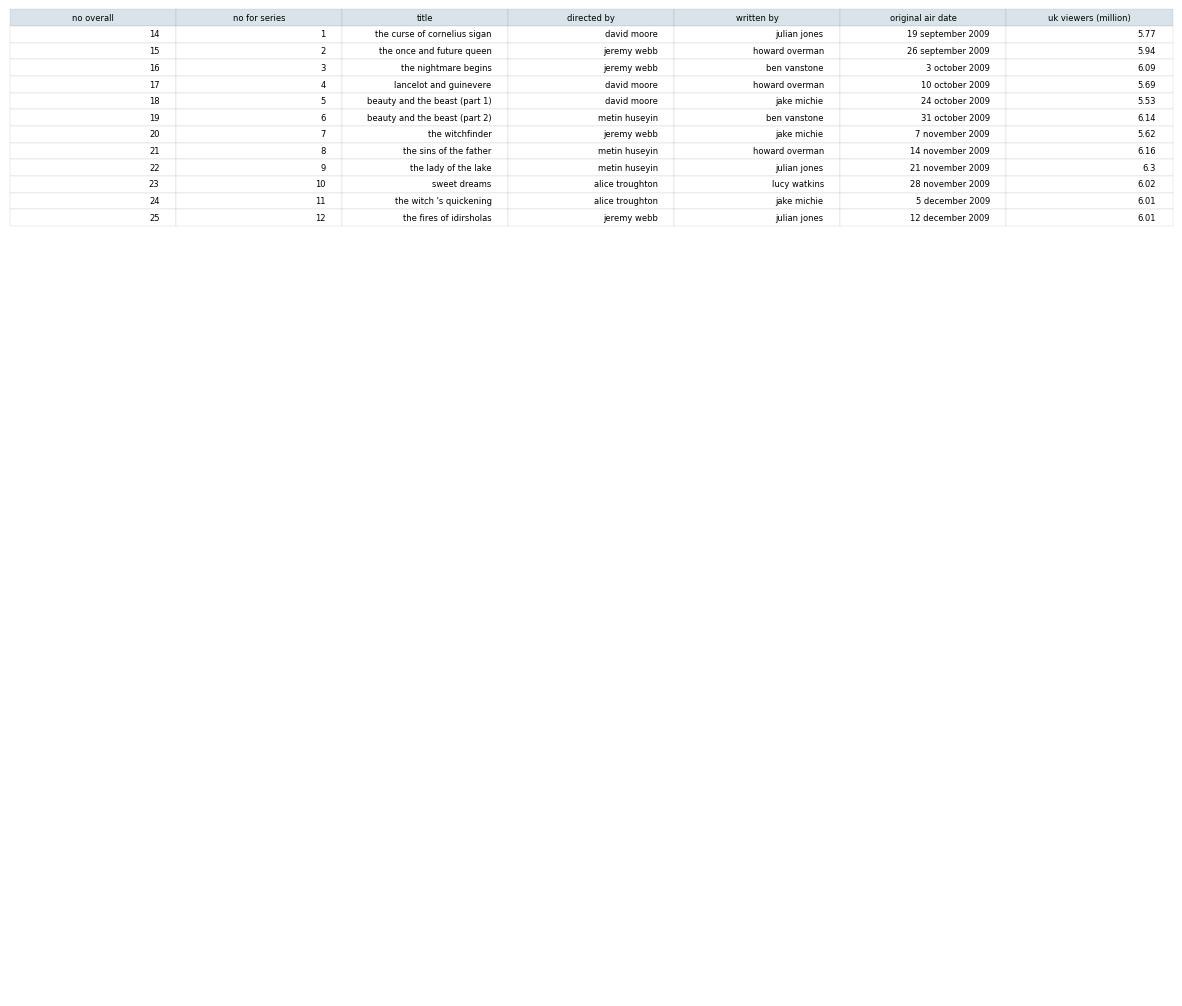

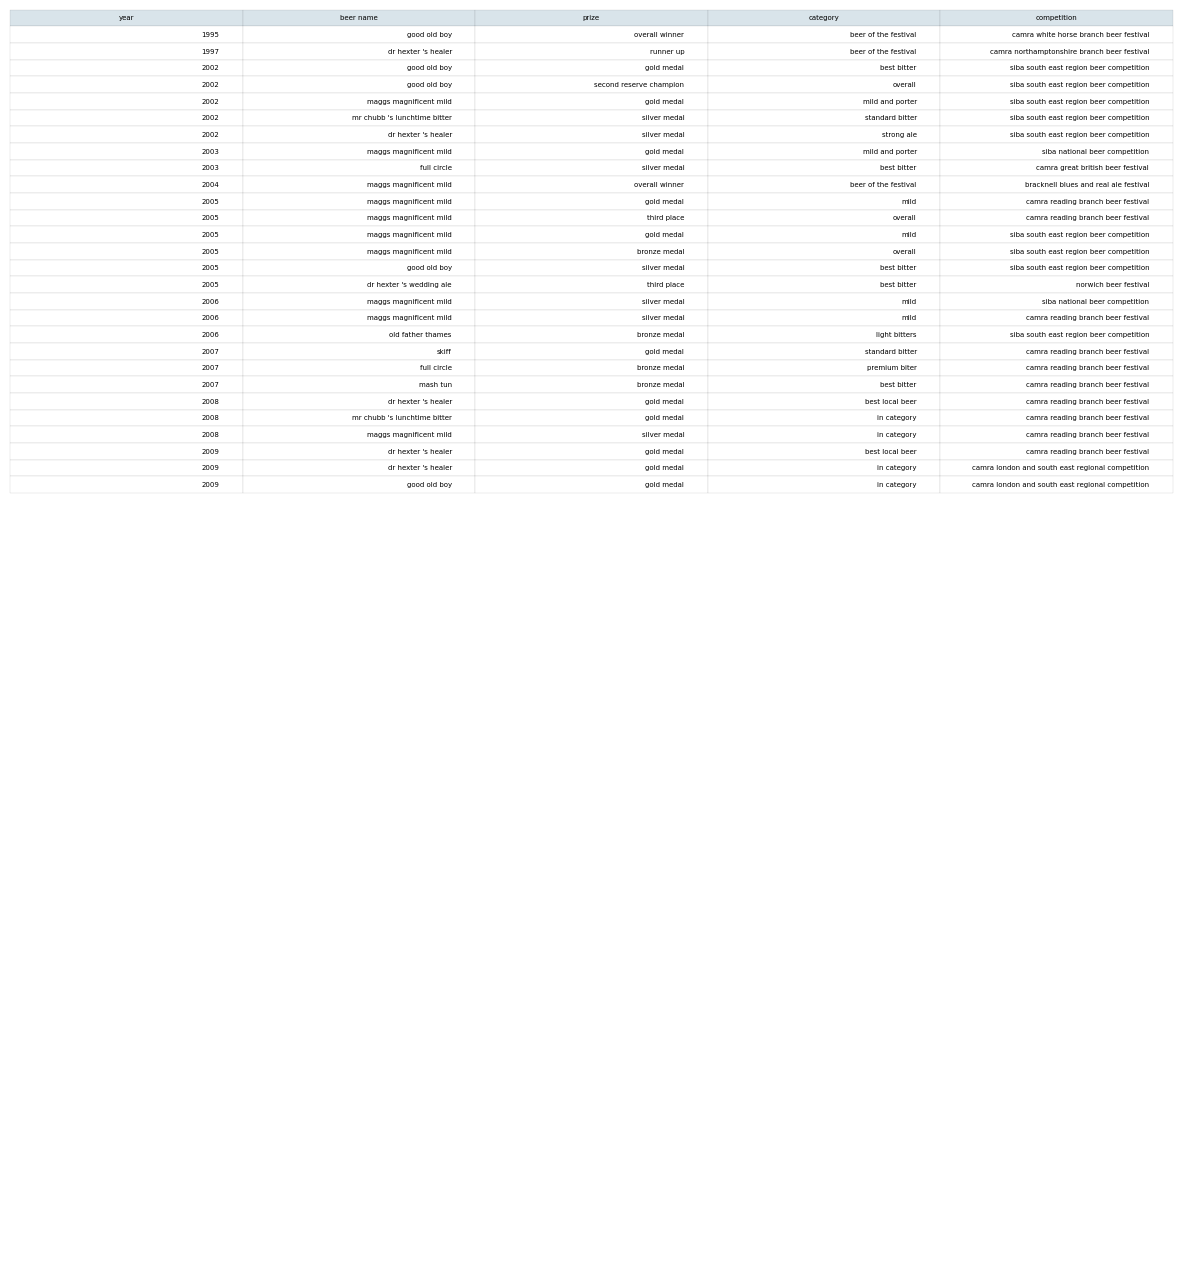

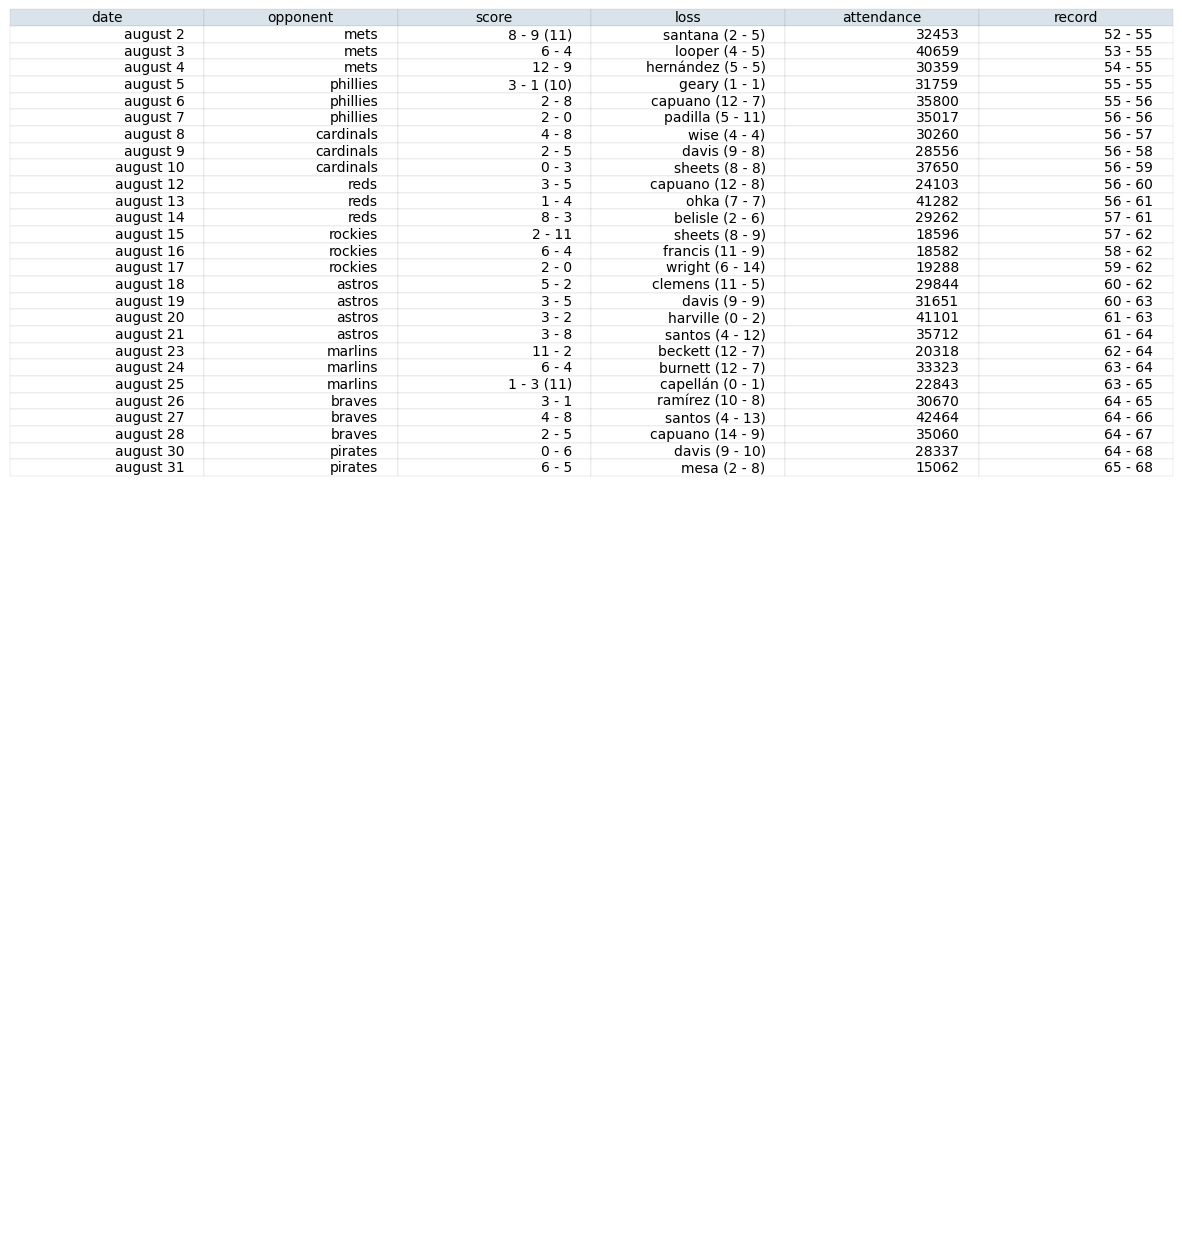

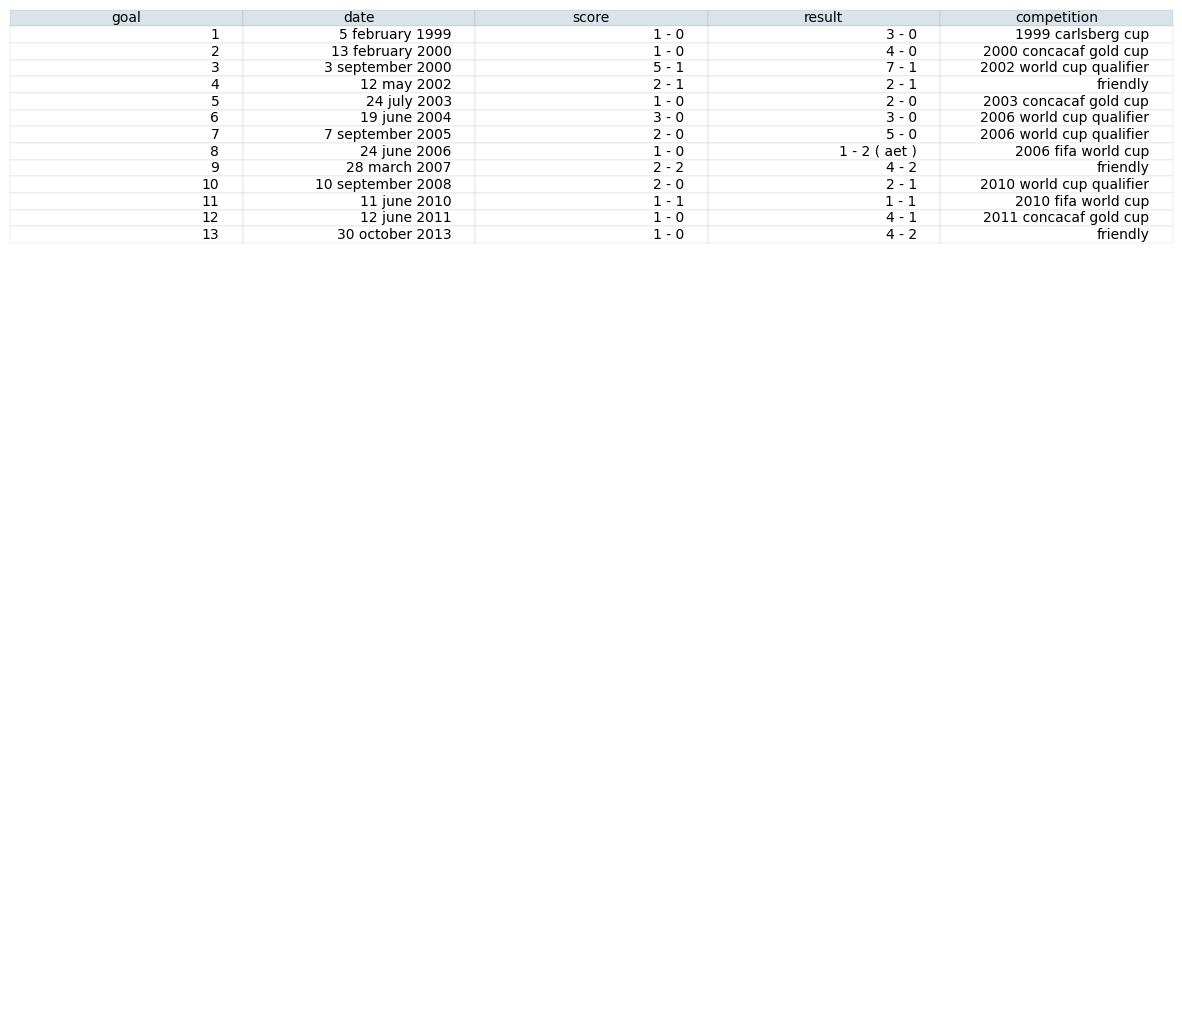

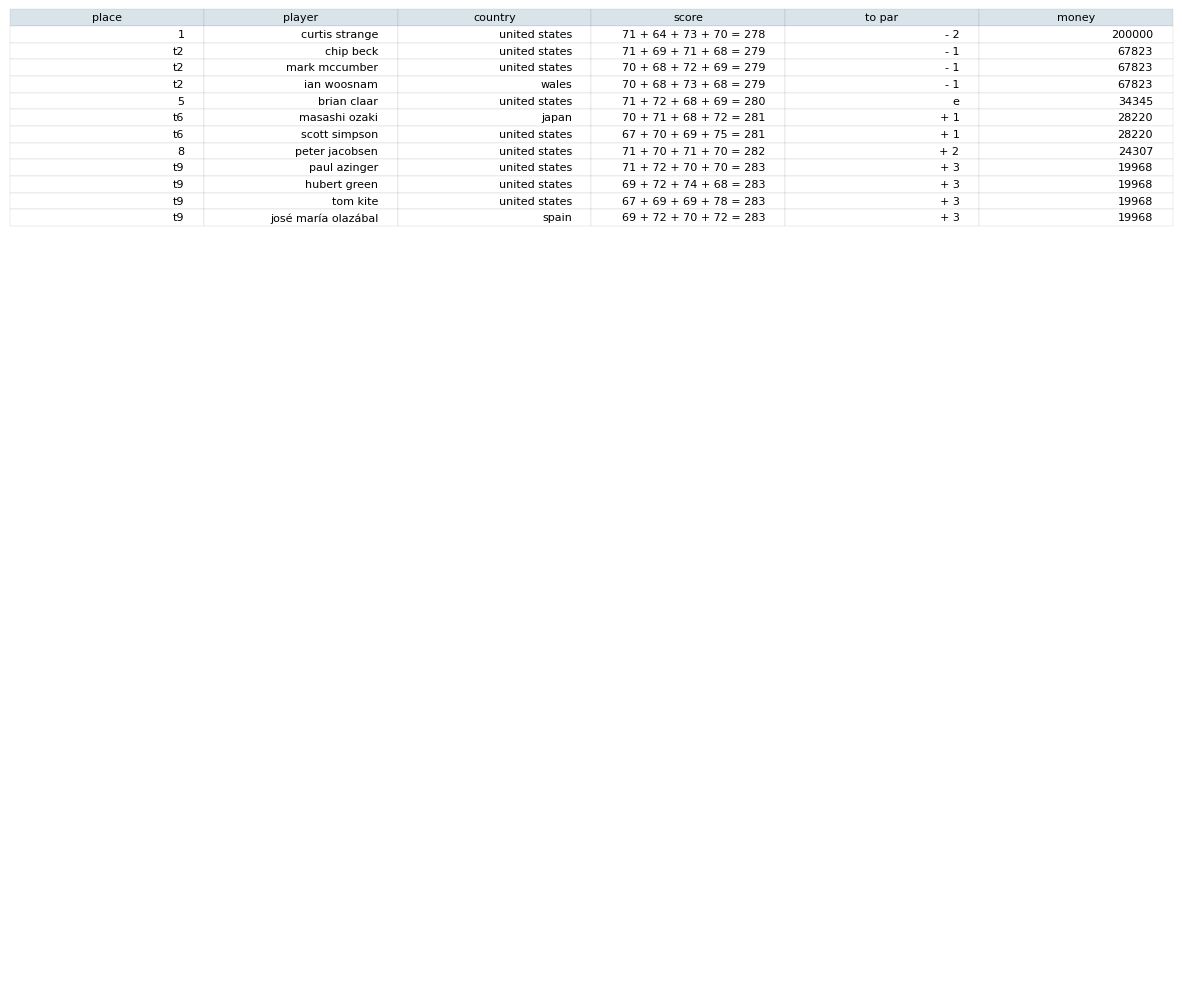

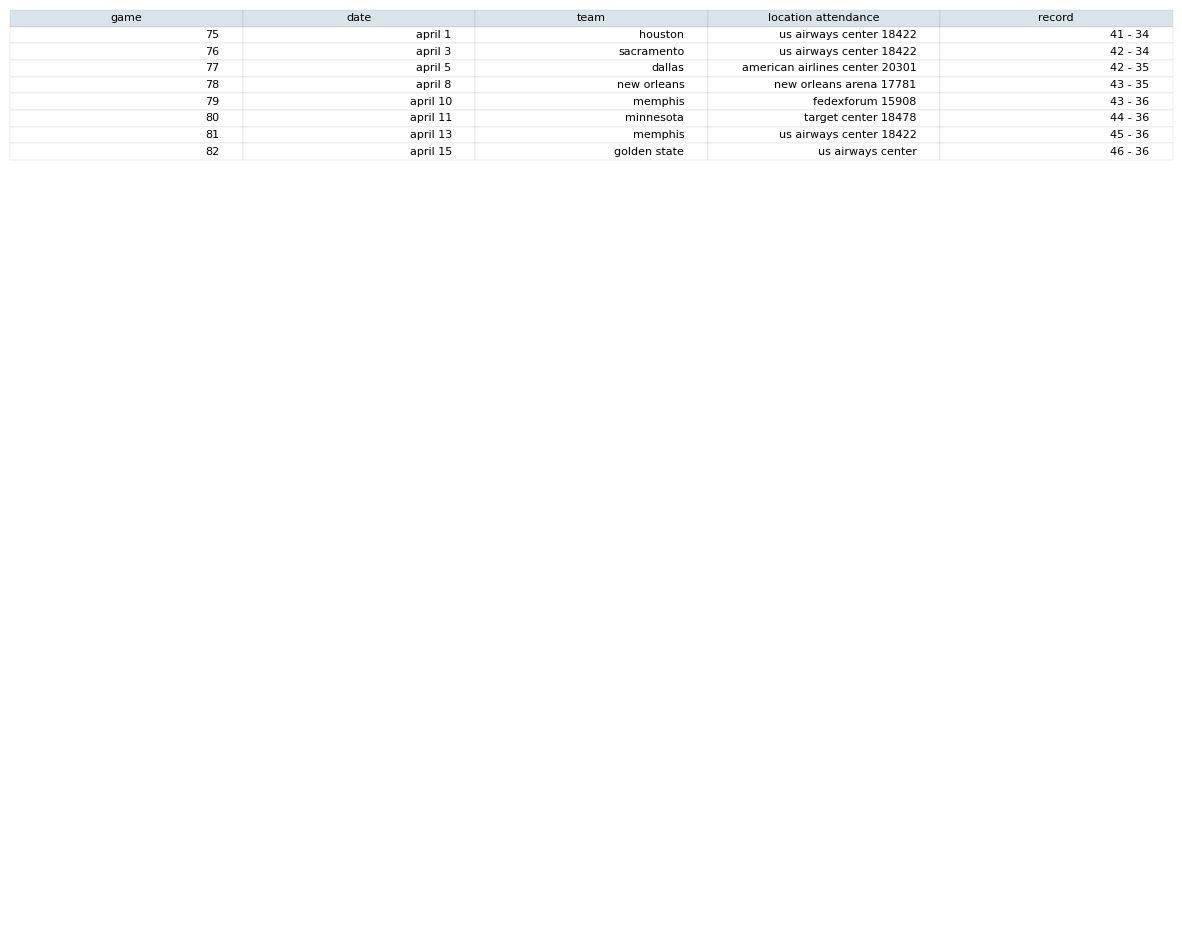

In [83]:
# get a list of file name and save them as pngs 
files = set(eval_data_results['key'])
# table_data = pd.read_csv(f'./all_csv/{table_Key}', sep='#')
for file in files:
    df = pd.read_csv(f'./all_csv/{file}', sep='#')
    questions = test_examples[file]
    caption = questions[2]
    html_table = df.to_html()
    # Render the HTML to an image using Matplotlib
    # Note: This step directly renders the DataFrame, not the HTML.
    # fig, ax = plt.subplots()

    plt.figure(figsize=(15, 10))
    plt.axis('off')  # Turn off axis
    # plt.suptitle(caption, fontsize=12, fontweight="bold", loc='top')
    table = plt.table(cellText=df.values, colLabels=df.columns, loc='top', colColours=['#D9E4EA']*len(df.columns))
    for (row, col), cell in table.get_celld().items():
        cell.set_linewidth(0.05)
    new_file_name = os.path.splitext(file)[0] + '.png'
    plt.savefig(f'./csv_images/{new_file_name}', bbox_inches='tight', dpi=150)

    


In [66]:
df_eval = eval_data_results[:3]
for row in df_eval:
    print(row)

key
prompt
expected_result
openai_result
llama_result
mixtral_result
claude_result


In [119]:
df_eval = eval_data_results[:1]
for index, row in df_eval.iterrows():
    statement = row['prompt'][1]['content']
    img_name = os.path.splitext(row['key'])[0] + '.png'
    img_url = f'./csv_images/{img_name}'
    text = row['prompt'][0]['content']
    start_index = text.find("data of ") + len("data of ")
    end_index = text.find(":")
    caption = text[start_index:end_index].strip()
    # print(f"{statement}, {img_url}, {caption}")
    # prompt = get_image_prompt(img_url, statement, caption)
    # print(prompt)
    response = get_llama_vision_response(prompt)
    print(response)


BadRequestError: Error code: 400 - {'error': {'message': "'messages.1' : for 'role:user' the following must be satisfied[('messages.1.content' : one of the following must be satisfied[('messages.1.content' : value must be a string) OR ('messages.1.content.0' : one of the following must be satisfied[('messages.1.content.0.text' : property 'text' is missing) OR ('messages.1.content.0.type' : value is not one of the allowed values ['image_url'])])])]", 'type': 'invalid_request_error'}}

In [95]:
pr1 = [
            {
                "role": "system",
                "content": {
                        "type": "text",
                        "text": f"You are a helpful assistant who can understand structured table data. You need to help identify if a statement is True/False based on the data of {caption} represented in a image. Response should only contain a single character 1 for True or 0 for False.",

                    }
            },
            {
                "role": "user",
                "content": [
                    # {
                    #     "type": "text",
                    #     "content": f"You are a helpful assistant who can understand structured table data. You need to help identify if a statement is True/False based on the data of {caption} represented in a image. Response should only contain a single character 1 for True or 0 for False.",

                    # },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    }
                ]
            },            
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text":f"{statement}"
                    }
                ]
            }
        ]


In [144]:
df_eval = eval_data_results
df_eval['llama32_11b_vision_result'] = None
df_eval['llama32_11b_vision_reason'] = None
failed_index = []
for index, row in df_eval.iterrows():
    statement = row['prompt'][1]['content']
    img_name = os.path.splitext(row['key'])[0] + '.png'
    img_url = f'./csv_images/{img_name}'
    # base64_image = encode_image(img_url)
    text = row['prompt'][0]['content']
    start_index = text.find("data of ") + len("data of ")
    end_index = text.find(":")
    caption = text[start_index:end_index].strip()
    # client = groq.Groq(api_key=os.getenv('GROQ_API_KEY'))
    prompt1 = get_image_prompt(img_url, statement, caption)
    # client = instructor.from_groq(groq.Groq(api_key=os.getenv('GROQ_API_KEY')), mode=instructor.Mode.JSON)
    try:
        response = get_llama_vision_response(prompt1)
        response = json.loads(response)
        # print(response)
        df_eval.at[index, 'llama32_11b_vision_result'] = response['is_true']
        df_eval.at[index, 'llama32_11b_vision_reason'] = response['reason']
    except:
        failed_index.append(index)


    # chat_completion = client.chat.completions.create(
    #     messages= prompt1,
    #     # [
    #     #     {
    #     #         "role": "user",
    #     #         "content":
    #     #         [
    #     #             {
    #     #                 "type": "text",                         
    #     #                 "text": f"You are a helpful assistant who can understand structured table data. You need to help identify if a statement is True/False based on the data of {caption} represented in a image. Response should only contain a single character 1 for True or 0 for False.",
    #     #             },
    #     #             {
    #     #                 "type": "image_url",
    #     #                 "image_url": {
    #     #                     "url": f"data:image/jpeg;base64,{base64_image}",
    #     #                 },
    #     #             },
    #     #             {
    #     #                 "type": "text",
    #     #                 "text":f"{statement}"
    #     #             }
    #     #         ],
    #     #     }
    #     # ],
    #     # response_model=StatementInfo,
    #     model="llama-3.2-11b-vision-preview",
        
    # )
    # print(chat_completion.choices[0].message.content)


In [145]:
df_eval.head()

,key,prompt,expected_result,openai_result,llama_result,mixtral_result,claude_result,llama32_11b_vision_result,llama32_11b_vision_reason
0,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,0,0.0,1,0,tony lema does not have 5 wins for the master ...
1,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,1.0,1,0,Tony Lema did not participate in The Open Cham...
2,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,1.0,1,1,The table shows that Tony Lema won the Open Ch...
3,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,0.0,1,1,according to the data
4,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,0,1.0,1,0,"according to the table data, tony lema did not..."


In [146]:
len(failed_index)

2

Accuracy OpenAI: 0.88, Llama: 0.76, Mixtral: 0.58, Claude: 0.84, Llama-vision: 0.57


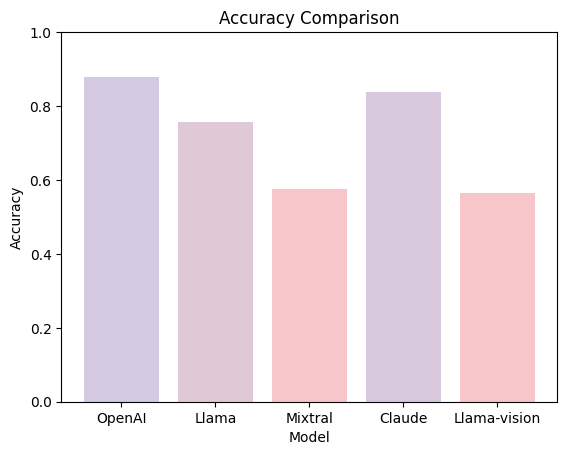

In [156]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime


# eval_data

# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# filename = f'results_{timestamp}.json'
# eval_data.to_json(f'./table_fact_check/{filename}', orient='records')

# eval_data['openai_result'] = eval_data['openai_result'].apply(lambda x : int(x))


df = df_eval
accuracy_openai = (df['expected_result'] == df['openai_result']).mean()
accuracy_llama = (df['expected_result'] == df['llama_result']).mean()
accuracy_mixtral = (df['expected_result'] == df['mixtral_result']).mean()
accuracy_claude = (df['expected_result'] == df['claude_result']).mean()
accuracy_llama_vision = (df['expected_result'] == df['llama32_11b_vision_result']).mean()
print(f'Accuracy OpenAI: {accuracy_openai:.2f}, Llama: {accuracy_llama:.2f}, Mixtral: {accuracy_mixtral:.2f}, Claude: {accuracy_claude:.2f}, Llama-vision: {accuracy_llama_vision:.2f}')


# Define a custom colormap
cmap = LinearSegmentedColormap.from_list("custom", [ "#87CEEB", "#FFC5C5", "#C5CAE9" ]) #"#C5CAE9"
methods = ['OpenAI', 'Llama', 'Mixtral', 'Claude', 'Llama-vision']
accuracy = [accuracy_openai, accuracy_llama, accuracy_mixtral, accuracy_claude, accuracy_llama_vision]
# Normalize the accuracy values to be between 0 and 1
norm = plt.Normalize(vmin=0, vmax=1)
# Create a bar chart with colored bars
for i, (method, acc) in enumerate(zip(methods, accuracy)):
    plt.bar(i, acc, color=cmap(norm(acc)))
# Set the title and labels
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(range(len(methods)), methods)
plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
# Show the plot
plt.show()

In [149]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'results_{timestamp}.json'
df_eval.to_json(f'./table_fact_check/{filename}', orient='records')